# 0. Introduction

## Structure of notebook
This notebook contains the codes that were used to explain feature selection and model estimation in the credit scoring industry.

The first half of the notebook explains how forward stepwise selection can be implemented to choose the right number and the right combination of variables using the sample dataset. The original code was adapted from [here](http://www.science.smith.edu/~jcrouser/SDS293/labs/2016/lab8/Lab%208%20-%20Subset%20Selection%20in%20Python.pdf).

The latter half of the notebook explains how algorithms are trained using a dummy example and linear regression, then compares the various performance metrics of different classification algorithms using the sample dataset.


## About the sample dataset
The original dataset used in this notebook is from the Kaggle competiton [Give Me some Credit](https://www.kaggle.com/c/GiveMeSomeCredit). The dataset contains information on 250,000 borrowers. The target variable is a binary variable, where 1 indicates the individual will experience financial distress in the next 2 years.




## Setting working environment

In [1]:
# import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.set_option("max_columns", None)

/Users/jk6653284/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [42]:
# read in dataset
train = pd.read_csv("cs-training.csv")
test = pd.read_csv("cs-test.csv")

# drop id, as it is not needed for this analysis
train = train.drop("Unnamed: 0", axis = 1)
test = test.drop("Unnamed: 0", axis = 1)

# 1. Feature selection

In [43]:
# import libraries to create forward selection from scratch
import itertools
import statsmodels.api as sm

In [59]:
# concat training and test data
df = pd.concat([train,test], axis = 0)

# drop null rows
df = df.dropna(axis = 0)

# create X and y
y = df.SeriousDlqin2yrs
X = df.drop(['SeriousDlqin2yrs'], axis = 1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using RSS.

In [60]:
# function to use subset of feature sets
# fit the model, and retrieve RSS scores
def processSubset(feature_set): 
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

# function to retrieve the best model with best features combination 
def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo)) # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results) # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.") # Return the best model, along with some other useful information about the model
    return best_model


def forward(predictors): 
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p])) 
        
    # Wrap everything up in a nice dataframe 
    models = pd.DataFrame(results) 
    
    # Choose the model with the highest RSS 
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [61]:
# create dataframe to see which feature selection combinations
# for each k number of features is the best
models = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
for i in range(1,8):
    models.loc[i] = getBest(i)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

/Users/jk6653284/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()


Processed  10 models on 1 predictors in 0.1136159896850586 seconds.
Processed  45 models on 2 predictors in 0.774317741394043 seconds.
Processed  120 models on 3 predictors in 3.0936079025268555 seconds.
Processed  210 models on 4 predictors in 6.667226076126099 seconds.
Processed  252 models on 5 predictors in 10.160486936569214 seconds.
Processed  210 models on 6 predictors in 10.610844850540161 seconds.
Processed  120 models on 7 predictors in 7.457716941833496 seconds.
Total elapsed time: 38.904654026031494 seconds.


In [62]:
# view the dataframe and see the RSS value for
# the best for each number of features
models

,RSS,model
1,7926.621721,<statsmodels.regression.linear_model.Regressio...
2,7792.828753,<statsmodels.regression.linear_model.Regressio...
3,7622.560133,<statsmodels.regression.linear_model.Regressio...
4,7548.078274,<statsmodels.regression.linear_model.Regressio...
5,7503.496443,<statsmodels.regression.linear_model.Regressio...
6,7500.762698,<statsmodels.regression.linear_model.Regressio...
7,7499.855863,<statsmodels.regression.linear_model.Regressio...


In [63]:
# access details of best model with 2 variables
print(models.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:       SeriousDlqin2yrs   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4353.
Date:                Mon, 19 Mar 2018   Prob (F-statistic):               0.00
Time:                        20:47:31   Log-Likelihood:                -6094.6
No. Observations:              120269   AIC:                         1.219e+04
Df Residuals:                  120267   BIC:                         1.221e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


We can see that the best model with 2 features uses 'NumberOfTime30-59DaysPastDueNotWorse' and 'age' as the predictor variables.

In [64]:
# create dataframe to see which feature selection combinations
# for each k number of features is the best
# using the forward stepwise method

models2 = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
predictors = []
for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

/Users/jk6653284/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


Processed  10 models on 1 predictors in 0.10665011405944824 seconds.
Processed  9 models on 2 predictors in 0.15630793571472168 seconds.
Processed  8 models on 3 predictors in 0.18880081176757812 seconds.
Processed  7 models on 4 predictors in 0.22074413299560547 seconds.
Processed  6 models on 5 predictors in 0.24050426483154297 seconds.
Processed  5 models on 6 predictors in 0.2804388999938965 seconds.
Processed  4 models on 7 predictors in 0.299083948135376 seconds.
Processed  3 models on 8 predictors in 0.23299098014831543 seconds.
Processed  2 models on 9 predictors in 0.1602790355682373 seconds.
Processed  1 models on 10 predictors in 0.09009504318237305 seconds.
Total elapsed time: 2.0207841396331787 seconds.


As you can see, the time taken to process the iteration is much shorter. Let's compare the result by looking at the model with 2 features.

In [66]:
# view the dataframe and see the RSS value for
# the best for each number of features
models2

,RSS,model
1,7926.621721,<statsmodels.regression.linear_model.Regressio...
2,7792.828753,<statsmodels.regression.linear_model.Regressio...
3,7622.560133,<statsmodels.regression.linear_model.Regressio...
4,7548.078274,<statsmodels.regression.linear_model.Regressio...
5,7503.496443,<statsmodels.regression.linear_model.Regressio...
6,7500.762698,<statsmodels.regression.linear_model.Regressio...
7,7499.855863,<statsmodels.regression.linear_model.Regressio...
8,7498.993753,<statsmodels.regression.linear_model.Regressio...
9,7498.971127,<statsmodels.regression.linear_model.Regressio...
10,7498.959617,<statsmodels.regression.linear_model.Regressio...


In [67]:
print(models2.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:       SeriousDlqin2yrs   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4353.
Date:                Mon, 19 Mar 2018   Prob (F-statistic):               0.00
Time:                        20:48:53   Log-Likelihood:                -6094.6
No. Observations:              120269   AIC:                         1.219e+04
Df Residuals:                  120267   BIC:                         1.221e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Again, the best variables for 2 variable combination are 'NumberOfTime30-59DaysPastDueNotWorse' and 'age'. We can also access individual scores by using the score method for each model. Let's look at the rsquared values.

In [71]:
# get rsquared scores for each best model 
# with features chosen using forward selection
for i in range(1,11):
    print("r-squared for {} variable(s): {}".format(i,models2.loc[i,'model'].rsquared))

r-squared for 1 variable(s): 0.051499135990021094
r-squared for 2 variable(s): 0.06750882462690821
r-squared for 3 variable(s): 0.08788319581617876
r-squared for 4 variable(s): 0.09679570726366216
r-squared for 5 variable(s): 0.10213037657774626
r-squared for 6 variable(s): 0.10245749692144424
r-squared for 7 variable(s): 0.10256600898004253
r-squared for 8 variable(s): 0.10266916924921698
r-squared for 9 variable(s): 0.10267187661327448
r-squared for 10 variable(s): 0.10267325394267535


# 2. Model estimation

Most simple models can be called from the scikit-learn library. Note that the algorithms require you to have numerical values for all the data fitted. This means you might need to use methods like one-hot coding to encode categorical variables. The dummy dataset and the credit scoring dataset used here contain only numerical variables, so no further pre-processing (except scaling for scale sensitive models) are necessary.

## 2-1. Training a linear model

In [72]:
# dummy example to show linear regression
annual_income = np.arange(1,6).reshape(-1, 1)
credit_score = np.array([1,1.8,4,4.2,4.5])
test_income = np.array([2.5]).reshape(-1, 1)

In [73]:
# import linear regression function
from sklearn.linear_model import LinearRegression

# initiate linear regression model
linear_model = LinearRegression()

# fit training data to initiated linear model above
linear_model.fit(annual_income, credit_score)

# predict target value using test feature data
predicted = linear_model.predict(test_income)
print("Predicted credit score for John with 2.5 income level:",predicted)

Predicted credit score for John with 2.5 income level: [2.63]


In [74]:
# view linear model
print("coefficient of annual income:",linear_model.coef_)
print("intercept of model:",linear_model.intercept_)
print("\nregression function:")
print("Credit score = (annual income * {:0.2f}) + {:0.2f}".format(linear_model.coef_[0],
                                                        linear_model.intercept_))

coefficient of annual income: [0.94]
intercept of model: 0.27999999999999936

regression function:
Credit score = (annual income * 0.94) + 0.28


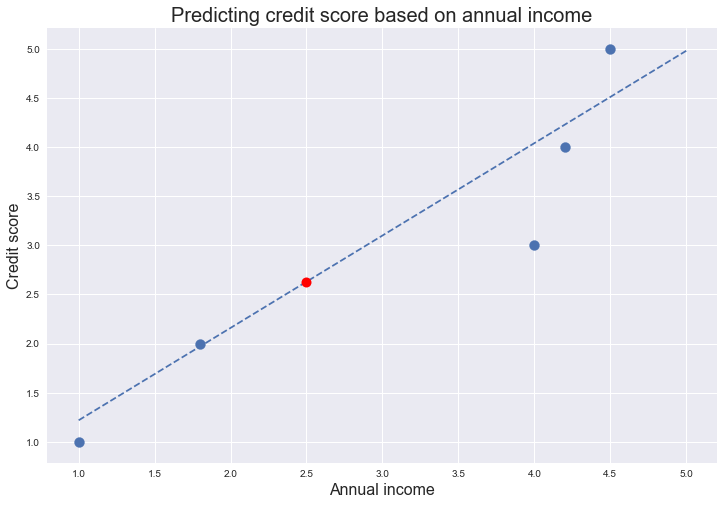

In [75]:
# visualize linear regression result using matplotlib
plt.figure(figsize = (12, 8))
predicted_regline = linear_model.predict(np.array([1,2,3,4,5]).reshape(-1,1))
plt.scatter(credit_score, annual_income.flatten(), s = 100)
plt.plot([1,2,3,4,5], predicted_regline, linestyle = "--")
plt.plot([2.5], predicted, marker='o', markersize=10, color="red")
plt.title("Predicting credit score based on annual income",fontsize = 20)
plt.xlabel("Annual income", fontsize = 16)
plt.ylabel("Credit score", fontsize = 16)
plt.show()

## 2-2. Comparing different classification algorithms

In [24]:
# import libraries needed to import classification algorithms and compare performances
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score # for performance scores

In [27]:
# divide into X and y using only complete cases
train_complete = train.dropna(axis = 0)
test = test.drop('SeriousDlqin2yrs', axis = 1)
test_complete = test.dropna(axis = 0)
y = train_complete.SeriousDlqin2yrs
X = train_complete.drop('SeriousDlqin2yrs', axis = 1)

# standardize features as some features are sensitive to scales
from sklearn.preprocessing import StandardScaler

# transform values using scaler
scaler = StandardScaler()
Xt = scaler.fit_transform(X)
test_t = scaler.fit_transform(test_complete)

In [28]:
# createfunction to print out performance of model
def classification_crossvalscore(model, x, y):
    acc = cross_val_score(model, x, y, scoring = 'accuracy', cv = 5)
    prec = cross_val_score(model, x, y, scoring = 'precision', cv = 5)
    recall = cross_val_score(model, x, y, scoring = 'recall', cv = 5)
    rocauc = cross_val_score(model, x, y, scoring = 'roc_auc', cv = 5)
    return acc, prec, recall, rocauc

In [29]:
# Linear discriminant analysis

lda = LinearDiscriminantAnalysis().fit(X,y)

# compute performance metrics for classification result
# measure time of fitting and prediction
start_time = time.time()
acc, prec, recall, rocauc = classification_crossvalscore(lda, X, y)
end_time = time.time()
print("time taken to fit and predict values:", end_time - start_time)
print("accuracy score(TP/N):", np.mean(acc))
print("precision score(TP/(TP+FP)):", np.mean(prec))
print("recall score(TP/(TP+FN)):", np.mean(recall))
print("rocauc score(rocaucarea):", np.mean(rocauc))

time taken to fit and predict values: 1.7898459434509277
accuracy score(TP/N): 0.9309880509406137
precision score(TP/(TP+FP)): 0.5203227366666109
recall score(TP/(TP+FN)): 0.092018646256575
rocauc score(rocaucarea): 0.6865558416311142


In [30]:
# list of variable coefficients of LDA
pd.Series(lda.coef_[0], X.columns).sort_values(ascending = False)

NumberOfTime30-59DaysPastDueNotWorse    0.810844
NumberOfTimes90DaysLate                 0.780351
NumberOfDependents                      0.085930
NumberRealEstateLoansOrLines            0.030234
MonthlyIncome                          -0.000005
DebtRatio                              -0.000032
RevolvingUtilizationOfUnsecuredLines   -0.000044
NumberOfOpenCreditLinesAndLoans        -0.010466
age                                    -0.024083
NumberOfTime60-89DaysPastDueNotWorse   -1.474621
dtype: float64

In [31]:
# logistic regression
logit = LogisticRegression().fit(Xt,y)

# compute performance metrics for classification result
# measure time of fitting and prediction
start_time = time.time()
acc, prec, recall, rocauc = classification_crossvalscore(logit, Xt, y)
end_time = time.time()
print("time taken to fit and predict values:", end_time - start_time)
print("accuracy score(TP/N):", np.mean(acc))
print("precision score(TP/(TP+FP)):", np.mean(prec))
print("recall score(TP/(TP+FN)):", np.mean(recall))
print("rocauc score(rocaucarea):", np.mean(rocauc))

time taken to fit and predict values: 5.566438913345337
accuracy score(TP/N): 0.9311792821407703
precision score(TP/(TP+FP)): 0.5773557830210695
recall score(TP/(TP+FN)): 0.03745393555702542
rocauc score(rocaucarea): 0.6909150899527043


In [32]:
# list of variable coefficients of logistic regression
pd.Series(logit.coef_[0], X.columns).sort_values(ascending = False)

NumberOfTime30-59DaysPastDueNotWorse    1.744670
NumberOfTimes90DaysLate                 1.519327
NumberOfDependents                      0.118865
NumberRealEstateLoansOrLines            0.096606
RevolvingUtilizationOfUnsecuredLines   -0.014678
NumberOfOpenCreditLinesAndLoans        -0.026388
DebtRatio                              -0.064146
age                                    -0.363024
MonthlyIncome                          -0.604661
NumberOfTime60-89DaysPastDueNotWorse   -3.104800
dtype: float64

In [33]:
# you can look at probability of each of the individuals too
# each array is a probabilty assigned for each row
# where the first value is the probability for 0 (i.e., not default probability)
# and the second value is the probability for 1 (i.e., default probability)
logit.predict_proba(Xt)

array([[0.79325201, 0.20674799],
       [0.92440668, 0.07559332],
       [0.83593448, 0.16406552],
       ...,
       [0.92705849, 0.07294151],
       [0.92319457, 0.07680543],
       [0.96433081, 0.03566919]])

In [34]:
# DT classifier
dt = DecisionTreeClassifier().fit(X,y)

# compute performance metrics for classification result
# measure time of fitting and prediction
start_time = time.time()
acc, prec, recall, rocauc = classification_crossvalscore(dt, X, y)
end_time = time.time()
print("time taken to fit and predict values:", end_time - start_time)
print("accuracy score(TP/N):", np.mean(acc))
print("precision score(TP/(TP+FP)):", np.mean(prec))
print("recall score(TP/(TP+FN)):", np.mean(recall))
print("rocauc score(rocaucarea):", np.mean(rocauc))

time taken to fit and predict values: 17.364422082901
accuracy score(TP/N): 0.8925325774769381
precision score(TP/(TP+FP)): 0.25218901773313707
recall score(TP/(TP+FN)): 0.2750999315654895
rocauc score(rocaucarea): 0.6053987560593382


In [36]:
# access variable importance
pd.Series(dt.feature_importances_, X.columns).sort_values(ascending = False)

RevolvingUtilizationOfUnsecuredLines    0.191398
DebtRatio                               0.189313
MonthlyIncome                           0.173623
NumberOfTimes90DaysLate                 0.121591
age                                     0.113162
NumberOfOpenCreditLinesAndLoans         0.078357
NumberOfDependents                      0.042559
NumberOfTime30-59DaysPastDueNotWorse    0.035750
NumberRealEstateLoansOrLines            0.031421
NumberOfTime60-89DaysPastDueNotWorse    0.022825
dtype: float64

In [37]:
# you can also export the visualized decision tree classifier
# as a png file or a pdf file
# uncomment the codes below to view the tree image

'''from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import graphviz

dot_data = StringIO()
graph = export_graphviz(dt, out_file=dot_data, 
                         feature_names=X.columns,  
                         class_names=['not_default', 'default'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())'''

"from sklearn.externals.six import StringIO\nfrom IPython.display import Image\nfrom sklearn.tree import export_graphviz\nimport pydotplus\nimport graphviz\n\ndot_data = StringIO()\ngraph = export_graphviz(dt, out_file=dot_data, \n                         feature_names=X.columns,  \n                         class_names=['not_default', 'default'],  \n                         filled=True, rounded=True,  \n                         special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())\nImage(graph.create_png())"

In [38]:
# NN: MLP classifier
# MLP is also sensitive to scaling, so use the scaled data
nn = MLPClassifier().fit(Xt,y)

# compute performance metrics for classification result
# measure time of fitting and prediction
start_time = time.time()
acc, prec, recall, rocauc = classification_crossvalscore(nn, Xt, y)
end_time = time.time()
print("time taken to fit and predict values:", end_time - start_time)
print("accuracy score(TP/N):", np.mean(acc))
print("precision score(TP/(TP+FP)):", np.mean(prec))
print("recall score(TP/(TP+FN)):", np.mean(recall))
print("rocauc score(rocaucarea):", np.mean(rocauc))

time taken to fit and predict values: 157.77098393440247
accuracy score(TP/N): 0.9339314649870367
precision score(TP/(TP+FP)): 0.5848528042091627
recall score(TP/(TP+FN)): 0.17255260724031393
rocauc score(rocaucarea): 0.8229550476915947


In [39]:
# Random forest classification
rf = RandomForestClassifier().fit(X,y)

# compute performance metrics for classification result
# measure time of fitting and prediction
start_time = time.time()
acc, prec, recall, rocauc = classification_crossvalscore(rf, X, y)
end_time = time.time()
print("time taken to fit and predict values:", end_time - start_time)
print("accuracy score(TP/N):", np.mean(acc))
print("precision score(TP/(TP+FP)):", np.mean(prec))
print("recall score(TP/(TP+FN)):", np.mean(recall))
print("rocauc score(rocaucarea):", np.mean(rocauc))

time taken to fit and predict values: 33.62950611114502
accuracy score(TP/N): 0.9307801835762763
precision score(TP/(TP+FP)): 0.5012133279325248
recall score(TP/(TP+FN)): 0.1609432938474798
rocauc score(rocaucarea): 0.7718011921194243


In [40]:
# list of variable coefficients of random forest classifier
pd.Series(rf.feature_importances_, X.columns).sort_values(ascending = False)

RevolvingUtilizationOfUnsecuredLines    0.195686
DebtRatio                               0.175643
MonthlyIncome                           0.164850
age                                     0.121204
NumberOfOpenCreditLinesAndLoans         0.087920
NumberOfTimes90DaysLate                 0.084851
NumberOfTime30-59DaysPastDueNotWorse    0.050414
NumberOfDependents                      0.045986
NumberOfTime60-89DaysPastDueNotWorse    0.040032
NumberRealEstateLoansOrLines            0.033414
dtype: float64